# TensorFlow Hub


[TensorFlow Hub](http://tensorflow.org/hub), kullanabileceğimiz önceden eğitilmiş TensorFlow modellerinin çevrim içi bir deposudur. Bu modeller ya olduğu gibi kullanılabilir ya da transferli öğrenme ile modifiye ederek (güncelleyerek) kullanılabilir.

Transfer öğrenimi, mevcut bir eğitilmiş modeli aldığınız ve onu ek iş yapmak için güncellediğiniz bir süreçtir. Bu, farklı olası çıktılar elde etmek için son katmanları eklerken ve yeniden eğitirken modelin büyük kısmını değiştirmeden devam edilmesi anlamına gelir.

Eğer merak ediyorsanız, burada TensorFlow Module Hub. içerisinde bulunan tüm modelleri bulabilirsiniz.

Bu Colab dosyasını başlatmadan önce yukarıdaki menüden Çalışma zamanı -> Çalışma Zamanını Yeniden Başlat ... seçeceğini seçerken colab ortamını sıfırlamalısınız.

# Gerekli Paketlerin İçeri Aktarılması
Daha önceki colab dosyalarından aşina olduğumuz paketlerin içeri aktarılması. Farklı olarak yukarıda anlatılan ve bu colab dosyasında bolca kullanılacak tensorflow_hub paketidir

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# TensorFlow Datasets Kullanılarak Çiçekler Veri Setinin İndirilmesi

Aşağıdaki hücrede, TensorFlow Veri Kümelerini kullanarak `Flowers` veri kümesini indiriyoruz. [TensorFlow Datasets belgesine](https://www.tensorflow.org/datasets/datasets#tf_flowers) bakarsanız, flower veri kümesinin adının `tf_flowers` olduğunu görürsünüz. Ayrıca bu veri kümesinin yalnızca bir eğitim kümesi olarak sunulduğunu görebilirsiniz. Bu nedenle, eğitim setinin bir `training_set` ve bir `validation_set` olarak bölmek için `tfds.splits` yöntemini kullanmamız gerekir. %70'i eğitim seti ve kalan %30 doğrulama seti olacak şekilde `[70,30]` bir bölme yapıyoruz. Ardından `tfds.load` kullanarak `tf_flowers` veri kümesini yüklüyoruz. 

In [4]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


# Çiçekler Veri Kümesi Hakkında Bilgilere Ulaşılması

Veri kümemiz sorunsuz bir şekilde indirildiğine göre, veri kümesindeki sınıflarn sayısını yazdırmak için veri kümesi bilgilerini kullanıyoruz ve ayrıca eğitim ve doğrulama kümemizde kaç tane görüntümüz olduğunu da öğreniyoruz.

In [5]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Toplam Sınıf Sayısı: {}'.format(num_classes))
print('Eğitim Görüntülerinin Toplam Sayısı: {}'.format(num_training_examples))
print('Doğrulama Görüntülerinin Toplam Sayısı: {} \n'.format(num_validation_examples))

Toplam Sınıf Sayısı: 5
Eğitim Görüntülerinin Toplam Sayısı: 2569
Doğrulama Görüntülerinin Toplam Sayısı: 1101 



Çiçekler veri kümesindeki tüm görüntüler aynı  boyutta değildir.

In [8]:
for i, example in enumerate(training_set.take(5)):
  print('{}. Görüntünün şekli : {} , etiketi/sınıfı: {}'.format(i+1, example[0].shape, example[1]))

1. Görüntünün şekli : (333, 500, 3) , etiketi/sınıfı: 2
2. Görüntünün şekli : (212, 320, 3) , etiketi/sınıfı: 3
3. Görüntünün şekli : (240, 320, 3) , etiketi/sınıfı: 3
4. Görüntünün şekli : (240, 320, 3) , etiketi/sınıfı: 4
5. Görüntünün şekli : (317, 500, 3) , etiketi/sınıfı: 3


# Görüntüleri Yeniden Biçimlendirelim ve Grupları (Batches) Oluşturalım

Aşağıdaki kod bloğunda, tüm görüntüler MobileNet v2 tarafından beklenen (224,224) çözünürlüğe yeniden biçimlendirilir ve normelleştirilem bir işlev oluşturur. İşlev, argüman olarak bir görüntü ve bir etiket alır. Sonrasında yeni görüntüue karşılık gelen etiketi döndürmelidir. Ardından 32 boyutunda eğitim ve doğrulama grupları oluşturuyoruz.

In [9]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

# TensorFlow Hub ile Basit Transfer Öğreniminin Yapılması

Şimdi aktarım öğrenimi yapmak için TensorFlow Hub kullanalım. Unutmayın, transfer (aktarım) öğrenimde önceden eğitilmiş bir modelin parçalarını yeniden kullanırız ve modelin son katmanı/virkaç katmanını değiştiririz. Ardından bu katmanları kendi veri kümemiz ile yeniden eğitiriz.

Aşağıdaki kod hücresinde MobileNet v2 kullanarak bir `feature_extractor` oluşturuyoruz. TensorFlow Hub üzerinden alınan kısmi modelin (son sınıflandırma katmanı olmayan) bir özellik vektörü (`feature_extractor`) olarak adlandırıldığını unutmayalım. Kullanılabilir özellik vektörlerinin listesini görmek için [TensorFlow Hub belgelerine](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) göz atabilirsiniz. Son olarak, `hub.KerasLayer`kullanarak doğru `input_shape` parametresiyle birlikte bir `feature_extractor` oluşturuyoruz.

In [10]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

## Önceden Eğitilmiş Modelin Dondurulması

Aşağıdaki kod satırı, özellik çıkarıcı (`feature_extractor`) katmanındaki değişkenleri dondurur. Böylece eğitim yalnızca son sınıflandırıcı katmanını değiştirir/günceller.

In [11]:
feature_extractor.trainable = False

## Sınıflandırma Başlığının Eklenmesi

Aşağıdaki hücrede bir `tf.keras.Sequential` modeli oluşturuyoruz. Önceden eğitilmiş modeli ve yeni sınıflandırma katmanını ekliyoruz. Sınıflandırma katmanının, çiçekler veri kümemizle aynı sayıda sınıfa sahip olması gereklidir.

In [12]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


# Modelin Eğitilmesi

Aşağıdaki blokta, bu modeli aynı diğer modellerde olduğu gibi `compile` ile derleyip `fit` ile eğitelim. Modeli yalnızca altı dönem (epochs) için eğitiyoruz.

In [13]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 37s 61ms/step - loss: 0.8451 - accuracy: 0.6886 - val_loss: 0.4719 - val_accuracy: 0.8510
Epoch 2/6
81/81 [==============================] - 4s 49ms/step - loss: 0.3936 - accuracy: 0.8653 - val_loss: 0.3690 - val_accuracy: 0.8819
Epoch 3/6
81/81 [==============================] - 4s 49ms/step - loss: 0.3014 - accuracy: 0.9031 - val_loss: 0.3338 - val_accuracy: 0.8965
Epoch 4/6
81/81 [==============================] - 4s 49ms/step - loss: 0.2554 - accuracy: 0.9272 - val_loss: 0.3186 - val_accuracy: 0.8919
Epoch 5/6
81/81 [==============================] - 4s 50ms/step - loss: 0.2170 - accuracy: 0.9377 - val_loss: 0.3189 - val_accuracy: 0.8856
Epoch 6/6
81/81 [==============================] - 4s 50ms/step - loss: 0.1903 - accuracy: 0.9455 - val_loss: 0.2961 - val_accuracy: 0.9055


Yalnızca 6 eğitim dönemine rağmen yaklaşık %90 doğruluk elde ettik. Bu kesinlikle çok iyi. Bu 80 eğitim dönemi ile yaklaşık %77 doğruluk elde ettiğimiz modele göre oldukça iyi bir gelişme.

Bu farklılığın nedeni, MobileNet v2'nin uzmanlar tarafından uzun bir süre boyunca özenle tasarlanmış, ardından büyük bir veri kümesi (ImageNet) üzerinde eğitilmiş olmasıdır.

# Eğitim ve Doğrulama Grafiklerinin Çizilmesi

Bu kod satırıyla eğitim ve doğrulama veri setlerimiz için doğruluk/kayıp grafiklerini çizebiliriz.

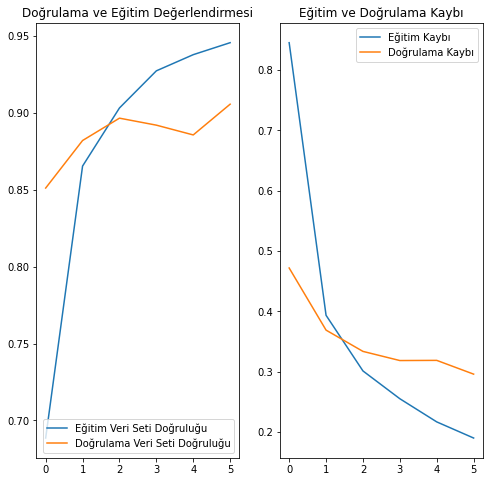

In [14]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Veri Seti Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Veri Seti Doğruluğu')
plt.legend(loc='lower right')
plt.title('Doğrulama ve Eğitim Değerlendirmesi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()

# Tahminlerin Kontrol Edilmesi

Aşağıdaki kod bloğunda, veri kümesin bilgisinden etiket adlarını alıyoruz ve bunları bir `NumPy` dizisine dönüştürüyoruz.

In [15]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


# Görüntü Grubu İçin Tahminlere Bakılması

Aşağıdaki hücredei bir `image_batch` ve buna karşılık gelen `label_batch` oluşturmak için `next()` işlevini kullanıyoruz. `numpy()` yöntemini kullanarak hem `image_batch` hem de `label_batch` dizilerini numpy dizilerine dönüştürüyoruz. Ardındani görüntü gruplarını modelimizde çalıştırmak ve tahminlerde bulunmak için `.predict()` yöntemini kullanıyoruz. Ardından her görüntü için en iyi tahminin indeksini almak için `np.argmax()` işlevini kullanıyoruz. Son olarak, en iyi tahminlerin indekslerini sınıf isimlerine dönüştürüyoruz.

In [16]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['tulips' 'dandelion' 'sunflowers' 'roses' 'tulips' 'roses' 'roses'
 'dandelion' 'dandelion' 'tulips' 'dandelion' 'dandelion' 'daisy' 'roses'
 'dandelion' 'sunflowers' 'roses' 'dandelion' 'roses' 'daisy' 'dandelion'
 'dandelion' 'tulips' 'roses' 'sunflowers' 'roses' 'tulips' 'daisy'
 'sunflowers' 'dandelion' 'tulips' 'dandelion']


## Gerçek Etiketleri ve Tahminlerin Yazdırılması

In [17]:
print("Gerçek Etiket: ", label_batch)
print("Tahmin Etiket: ", predicted_ids)

Gerçek Etiket:  [2 1 3 4 2 4 4 0 0 2 0 0 1 4 0 3 4 0 4 1 0 0 2 4 3 4 2 1 3 0 2 0]
Tahmin Etiket:  [2 0 3 4 2 4 4 0 0 2 0 0 1 4 0 3 4 0 4 1 0 0 2 4 3 4 2 1 3 0 2 0]


## Model Tahminlerinin Görselleştirilmesi

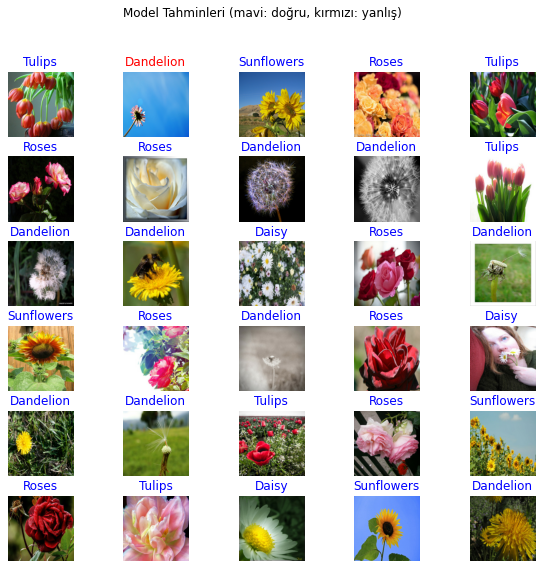

In [18]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model Tahminleri (mavi: doğru, kırmızı: yanlış)")

# Inception Modeli ile Transfer Öğrenimi Yapılması

[TensorFlow dokümantasyonuna](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) gittiğimizde ve `tf2-preview/inception_v4/feature_vector` seçeneğine tıklayalım. Bu özellik vektörüü Inception v3 modeline karşılık gelir.

 Aşağıdaki kod bloğunda, çiçekler veri kümesindeki görüntüleri sınıflandırmak için mnceden eğitilmiş model olarak Inception v3 modelini kullanıyoruz. Inception v3 modeli girdi olarak 299 x 299 piksel çözünürlüğe sahip görüntüler bekler. Inception v3 ile elde ettiğimiz doğruluk ile MobileNet v2 arasında nasıl bir fark olacak görelim

In [19]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [20]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 22s 196ms/step - loss: 0.7391 - accuracy: 0.7337 - val_loss: 0.4486 - val_accuracy: 0.8538
Epoch 2/6
81/81 [==============================] - 13s 157ms/step - loss: 0.3914 - accuracy: 0.8762 - val_loss: 0.3698 - val_accuracy: 0.8765
Epoch 3/6
81/81 [==============================] - 13s 156ms/step - loss: 0.3096 - accuracy: 0.9035 - val_loss: 0.3120 - val_accuracy: 0.8974
Epoch 4/6
81/81 [==============================] - 13s 157ms/step - loss: 0.2623 - accuracy: 0.9183 - val_loss: 0.2949 - val_accuracy: 0.8965
Epoch 5/6
81/81 [==============================] - 13s 159ms/step - loss: 0.2346 - accuracy: 0.9264 - val_loss: 0.2881 - val_accuracy: 0.8955
Epoch 6/6
81/81 [==============================] - 13s 160ms/step - loss: 0.2006 - accuracy: 0.9420 - val_loss: 0.2722 - val_accuracy: 0.8992


Sonuç olarak MobileNet modeline oldukça yaklaşmış olsa da Inception v3 modeli çok az bir farkla bu colab dosyasında geride kalmıştır.